In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import time
import math

%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv('../../datathon.csv')
data[:10]

,Unnamed: 0,time,refID_coin,price,marketCap,CirculatingSupply,Volume24h,Movement1h,Movement24h
0,0,2018-01-17 11:25:00,1442,10756.000000,180786170372,16807937,17884600000,-1.42,-11.40
1,1,2018-01-17 11:25:00,1443,960.930000,93242345727,97033038,7990730000,-2.37,-12.48
2,2,2018-01-17 11:25:00,1444,1.130000,43630734374,38739142811,6058320000,-3.03,-18.17
3,3,2018-01-17 11:25:00,1445,1744.130000,29504008303,16916175,1544790000,-3.20,-12.15
4,4,2018-01-17 11:25:00,1446,0.544258,14111015557,25927070538,1511130000,-2.56,-14.91
5,5,2018-01-17 11:25:00,1448,176.140000,9651298201,54793958,1353810000,-1.36,-12.67
6,6,2018-01-17 11:25:00,1447,0.887129,7984160999,8999999999,174228000,-0.79,-20.52
7,7,2018-01-17 11:25:00,1449,119.860000,7791225000,65000000,1366290000,-3.92,-21.24
8,8,2018-01-17 11:25:00,1450,0.411229,7357217335,17890803748,443714000,-1.09,-14.33
9,9,2018-01-17 11:25:00,1451,2.480000,6905187082,2779530283,245908000,-1.79,-16.55


In [3]:
stage_1_coins = [1442, 1445, 1456, 1446, 1453, 1447, 1452, 1443, 1457, 1451, 1460, 1448, 1454, 1477, 1449, 1444, 1450, 1474, 1455, 1465]
d = data.set_index('time')
d = d[d['refID_coin'].isin(stage_1_coins)]
d[:10]

,Unnamed: 0,refID_coin,price,marketCap,CirculatingSupply,Volume24h,Movement1h,Movement24h
time,,,,,,,,
2018-01-17 11:25:00,0,1442,10756.000000,180786170372,16807937,17884600000,-1.42,-11.40
2018-01-17 11:25:00,1,1443,960.930000,93242345727,97033038,7990730000,-2.37,-12.48
2018-01-17 11:25:00,2,1444,1.130000,43630734374,38739142811,6058320000,-3.03,-18.17
2018-01-17 11:25:00,3,1445,1744.130000,29504008303,16916175,1544790000,-3.20,-12.15
2018-01-17 11:25:00,4,1446,0.544258,14111015557,25927070538,1511130000,-2.56,-14.91
2018-01-17 11:25:00,5,1448,176.140000,9651298201,54793958,1353810000,-1.36,-12.67
2018-01-17 11:25:00,6,1447,0.887129,7984160999,8999999999,174228000,-0.79,-20.52
2018-01-17 11:25:00,7,1449,119.860000,7791225000,65000000,1366290000,-3.92,-21.24
2018-01-17 11:25:00,8,1450,0.411229,7357217335,17890803748,443714000,-1.09,-14.33


In [4]:
currencies = pd.read_csv('./data/CSVData_coin.csv')
currencies[:10]

,Id,name,Name,Date,Tag
0,1442,bitcoin,Bitcoin,2018-01-15 20:40:27.557,BTC
1,1443,ethereum,Ethereum,2018-01-15 20:40:27.557,ETH
2,1444,ripple,Ripple,2018-01-15 20:40:27.557,XRP
3,1445,bitcoin-cash,Bitcoin Cash,2018-01-15 20:40:27.560,BCH
4,1446,cardano,Cardano,2018-01-15 20:40:27.560,ADA
5,1447,nem,Nem,2018-01-15 20:40:27.560,XEM
6,1448,litecoin,Litecoin,2018-01-15 20:40:27.560,LTC
7,1449,neo,Neo,2018-01-15 20:40:27.560,NEO
8,1450,stellar,Stellar,2018-01-15 20:40:27.560,XLM
9,1451,iota,Iota,2018-01-15 20:40:27.560,MIOTA


In [5]:
frames = {}
for coin in stage_1_coins:
    name = currencies[currencies['Id'].isin([str(coin)])].iloc[0].Tag
    frames[name] = d[d['refID_coin'].isin([coin])].price.values

In [6]:
frames['NEO'][:10]

array([ 119.86,  119.69,  120.18,  119.89,  119.12,  117.25,  115.08,
        114.67,  115.78,  114.76])

In [7]:
# df = pd.DataFrame(frames['BTC'])
# for key in frames:
#     df.join(frames[key], rsuffix='_'+key)

In [8]:
df = pd.DataFrame(frames)
df[:10]

,ADA,BCH,BTC,BTG,DASH,DOGE,EOS,ETC,ETH,LSK,LTC,MIOTA,NEO,TRX,USDT,XEM,XLM,XMR,XRP,ZEC
0,0.544258,1744.13,10756.0,181.82,761.64,0.006842,9.54,28.14,960.93,18.94,176.14,2.48,119.86,0.052420,1.03,0.887129,0.411229,312.89,1.13,468.34
1,0.545643,1742.58,10788.1,182.10,758.21,0.006857,9.55,28.10,961.11,18.90,176.17,2.50,119.69,0.052255,1.03,0.892606,0.412253,313.80,1.13,467.89
2,0.544555,1751.49,10807.5,182.31,759.99,0.006892,9.61,28.15,961.68,19.08,176.36,2.52,120.18,0.052749,1.03,0.903337,0.412866,315.04,1.14,469.04
3,0.539331,1742.52,10776.1,181.60,755.19,0.006868,9.51,27.84,954.97,19.06,175.37,2.51,119.89,0.052214,1.03,0.894009,0.409000,312.10,1.12,464.66
4,0.538712,1730.45,10729.7,180.88,754.11,0.006899,9.48,27.76,953.37,19.00,174.30,2.50,119.12,0.052337,1.03,0.881417,0.407859,310.39,1.11,464.11
5,0.532169,1708.89,10653.3,178.25,746.01,0.006879,9.40,27.43,946.03,18.78,173.10,2.46,117.25,0.051901,1.03,0.873802,0.405104,307.71,1.09,460.67
6,0.524423,1676.88,10529.0,172.39,737.34,0.006705,9.22,26.87,933.59,18.43,170.48,2.39,115.08,0.051212,1.04,0.850425,0.394690,302.32,1.06,453.52
7,0.519785,1661.84,10457.1,171.48,732.41,0.006652,9.20,26.63,926.09,18.21,169.98,2.38,114.67,0.050371,1.03,0.839822,0.391171,300.85,1.08,447.74
8,0.525534,1679.47,10492.2,173.29,739.33,0.006684,9.28,26.82,929.29,18.43,170.62,2.37,115.78,0.050971,1.02,0.858221,0.395881,303.87,1.08,450.78
9,0.523623,1678.73,10465.7,171.65,733.06,0.006686,9.25,26.69,928.10,18.33,169.93,2.35,114.76,0.050990,1.03,0.842758,0.391705,301.53,1.07,450.15


In [9]:
def get_series(data, history_size, output_size=1):
    features = 1 if type(data) is list else data.shape[1]
    rows = len(data) if type(data) is list else data.shape[0]

    print(features)
#     df = pd.DataFrame(data)
    frames_X = np.zeros([rows - history_size, history_size, features])
    frames_Y = np.zeros([rows - history_size, features])

    for timeframe in range(rows - history_size - output_size):
        frames_X[timeframe] = data[timeframe: timeframe + history_size]
        frames_Y[timeframe] = data[timeframe + history_size : timeframe + history_size + output_size]

    return frames_X, frames_Y

In [72]:
scaler = MinMaxScaler(feature_range=(-1, 1))
prices = scaler.fit_transform(df)

In [73]:
frames_X, frames_Y = get_series(prices, 20)

20


In [74]:
frames_X[0, 0]

array([ 0.39257271,  0.44088266,  0.33463175,  0.36457674,  0.35964187,
        0.36362107, -0.05334462, -0.05819398,  0.25512534, -0.31956352,
       -0.04692023,  0.37440758,  0.14343664, -0.33212536,  0.82586891,
        0.33107862,  0.02764236,  0.28683879, -0.01624983,  0.46354022])

In [103]:
frames_Y[0]

array([ 0.30672768,  0.32403725,  0.24229667,  0.28435719,  0.20912202,
        0.22665321, -0.09906859, -0.15652174,  0.14313317, -0.33671083,
       -0.13685628,  0.27962085,  0.08599708, -0.33871225,  0.82586891,
        0.20910689, -0.08214508,  0.11704975, -0.10093732,  0.39925807])

In [116]:
def initialize_model(window_size, dropout_value, loss_function, optimizer, num_features):
    model = Sequential()

    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(window_size, num_features)))
    model.add(Dropout(dropout_value))
    
    model.add(Bidirectional(LSTM(10, return_sequences=False)))
#     model.add(Dense(5,activation='relu'))
    model.add(Dense(units=num_features))
    
#     model.add(Activation(activation_function))

    model.compile(loss=loss_function, optimizer=optimizer)
    
    return model


In [117]:
model = initialize_model(20, 0.2, 'mse', 'adam', 20)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_23 (Bidirectio (None, 20, 100)           28400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 20, 100)           0         
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 20)                8880      
_________________________________________________________________
dense_15 (Dense)             (None, 20)                420       
Total params: 37,700
Trainable params: 37,700
Non-trainable params: 0
_________________________________________________________________


In [118]:
from keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(patience=5)
model.fit(frames_X, frames_Y, batch_size=256, epochs=100, shuffle=False, validation_split=0.1, callbacks=[earlyStopping])

Train on 13660 samples, validate on 1518 samples
Epoch 1/100
13660/13660 [==============================] - 6s 454us/step - loss: 0.1273 - val_loss: 0.2381
Epoch 2/100
13660/13660 [==============================] - 4s 261us/step - loss: 0.0595 - val_loss: 0.1212
Epoch 3/100
13660/13660 [==============================] - 4s 263us/step - loss: 0.0322 - val_loss: 0.0788
Epoch 4/100
13660/13660 [==============================] - 4s 257us/step - loss: 0.0222 - val_loss: 0.0373
Epoch 5/100
13660/13660 [==============================] - 4s 265us/step - loss: 0.0184 - val_loss: 0.0383
Epoch 6/100
13660/13660 [==============================] - 4s 272us/step - loss: 0.0167 - val_loss: 0.0279
Epoch 7/100
13660/13660 [==============================] - 4s 260us/step - loss: 0.0158 - val_loss: 0.0277
Epoch 8/100
13660/13660 [==============================] - 4s 260us/step - loss: 0.0164 - val_loss: 0.0242
Epoch 9/100
13660/13660 [==============================] - 4s 261us/step - loss: 0.0127 - val_l

In [119]:
pred = model.predict(frames_X)

In [120]:
pred = scaler.inverse_transform(pred)

In [121]:
pred[:10]

array([[  5.27199745e-01,   1.50197375e+03,   1.00214160e+04,
          1.75327286e+02,   7.43386108e+02,   6.67859893e-03,
          9.07558155e+00,   2.78261738e+01,   8.63118530e+02,
          2.20360966e+01,   1.82036514e+02,   2.28589964e+00,
          1.15957207e+02,   5.90845197e-02,   1.01266277e+00,
          9.15535629e-01,   3.98275852e-01,   2.84736206e+02,
          1.29899538e+00,   4.78543945e+02],
       [  5.27609348e-01,   1.50153345e+03,   1.00281162e+04,
          1.75204712e+02,   7.43617432e+02,   6.67108735e-03,
          9.09484673e+00,   2.77517834e+01,   8.62095276e+02,
          2.20626564e+01,   1.82261551e+02,   2.28249264e+00,
          1.16170921e+02,   5.89713193e-02,   1.01303411e+00,
          9.11032557e-01,   3.98329914e-01,   2.85434601e+02,
          1.29317701e+00,   4.77468170e+02],
       [  5.26950479e-01,   1.49819702e+03,   1.00273877e+04,
          1.74647491e+02,   7.43024902e+02,   6.65250001e-03,
          9.09958076e+00,   2.76573639e+01

In [122]:
results = pd.DataFrame(pred, columns=list(df.columns.values))
results[:10]

,ADA,BCH,BTC,BTG,DASH,DOGE,EOS,ETC,ETH,LSK,LTC,MIOTA,NEO,TRX,USDT,XEM,XLM,XMR,XRP,ZEC
0,0.527200,1501.973755,10021.416016,175.327286,743.386108,0.006679,9.075582,27.826174,863.118530,22.036097,182.036514,2.285900,115.957207,0.059085,1.012663,0.915536,0.398276,284.736206,1.298995,478.543945
1,0.527609,1501.533447,10028.116211,175.204712,743.617432,0.006671,9.094847,27.751783,862.095276,22.062656,182.261551,2.282493,116.170921,0.058971,1.013034,0.911033,0.398330,285.434601,1.293177,477.468170
2,0.526950,1498.197021,10027.387695,174.647491,743.024902,0.006653,9.099581,27.657364,859.088257,22.043055,182.380096,2.272859,116.219490,0.058727,1.013443,0.904908,0.397963,285.852936,1.285277,476.154633
3,0.524747,1490.007568,10008.526367,173.481003,741.004883,0.006612,9.079193,27.508017,852.914551,21.974876,182.133301,2.254596,115.964737,0.058275,1.013828,0.895908,0.396815,285.409271,1.273820,474.368439
4,0.521191,1476.988892,9967.438477,171.793076,737.381348,0.006557,9.025990,27.332312,844.980835,21.860563,181.426697,2.232650,115.345222,0.057673,1.013937,0.886341,0.394667,284.090210,1.261828,472.726410
5,0.517220,1462.123901,9916.164062,170.099838,733.454407,0.006502,8.951177,27.101870,838.461060,21.738688,180.577576,2.214237,114.707809,0.057068,1.013798,0.876266,0.392287,282.547668,1.250343,471.200104
6,0.514665,1452.073364,9878.791992,169.079956,730.792419,0.006455,8.903301,26.885944,832.892212,21.704737,179.882965,2.197377,114.161346,0.056660,1.013708,0.867636,0.390850,281.112976,1.239904,469.788879
7,0.511582,1444.550415,9852.370117,168.175964,726.872864,0.006415,8.839340,26.787836,828.072998,21.640003,179.031403,2.186075,113.584175,0.056357,1.013357,0.862454,0.389026,279.759583,1.233307,469.517120
8,0.509739,1440.109741,9828.401367,167.818634,724.926697,0.006397,8.797125,26.679659,827.174683,21.643120,178.764038,2.183213,113.376183,0.056201,1.013118,0.857960,0.387751,279.242340,1.229249,468.965118
9,0.509361,1436.029297,9815.661133,167.722351,725.454224,0.006386,8.797732,26.510151,826.489380,21.703037,178.924484,2.178864,113.412949,0.056030,1.013286,0.851990,0.387759,279.123016,1.222926,467.496796


In [123]:
results.to_csv('predictions/all_coins.csv')

In [124]:
Y = scaler.inverse_transform(frames_Y)
Y = pd.DataFrame(Y, columns=list(df.columns.values))

In [125]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true + 1e-10 - y_pred) / y_true + 1e-10)) * 100

****** ADA ********
MAPE 5.87821371602


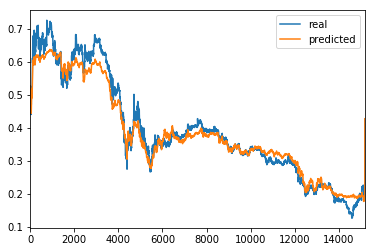

****** BCH ********
MAPE 3.44047292641


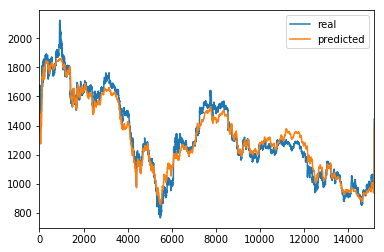

****** BTC ********
MAPE 3.55557469353


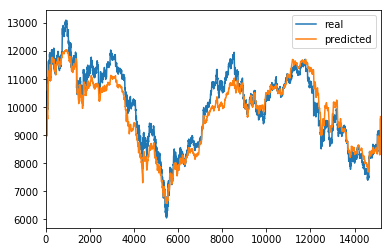

****** BTG ********
MAPE 5.74006599071


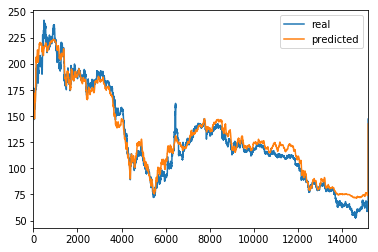

****** DASH ********
MAPE 3.54348068543


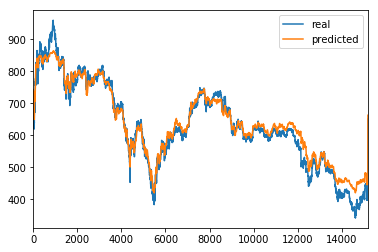

****** DOGE ********
MAPE 3.81551252278


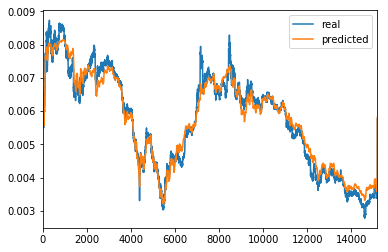

****** EOS ********
MAPE 9.36385331242


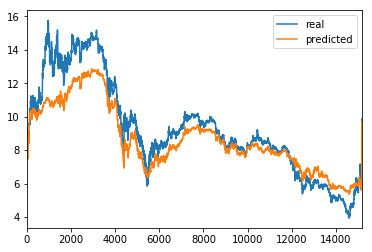

****** ETC ********
MAPE 4.84292052909


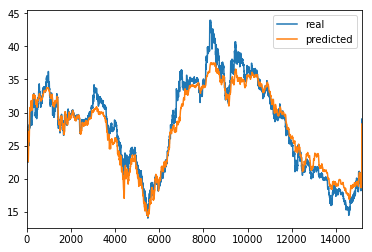

****** ETH ********
MAPE 4.56946499657


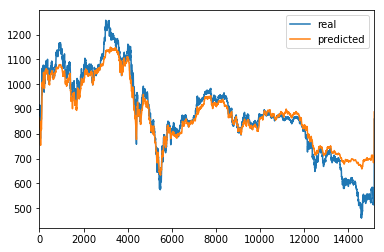

****** LSK ********
MAPE 4.4379977131


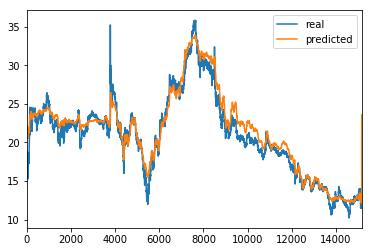

****** LTC ********
MAPE 3.64268927338


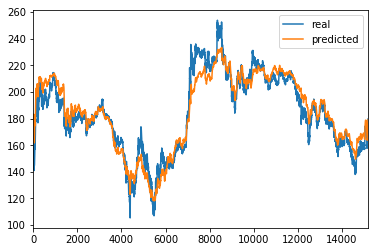

****** MIOTA ********
MAPE 4.73516286939


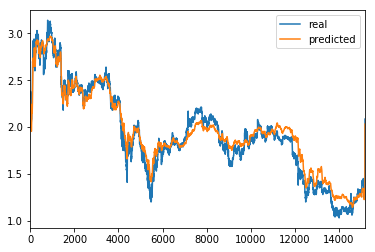

****** NEO ********
MAPE 6.21474221237


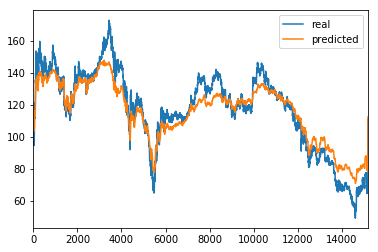

****** TRX ********
MAPE 8.43513940671


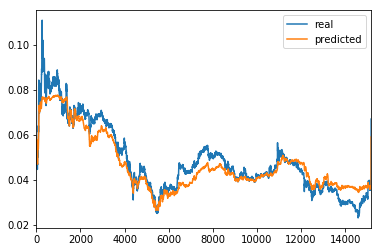

****** USDT ********
MAPE 0.449204458398


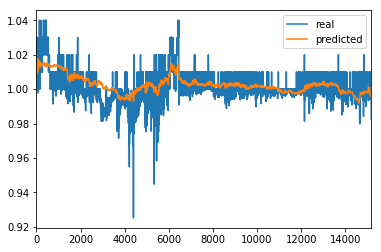

****** XEM ********
MAPE 6.92366668489


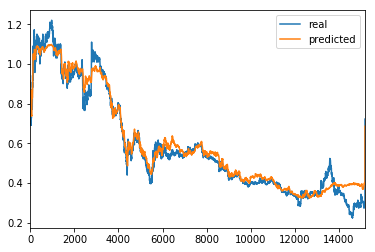

****** XLM ********
MAPE 7.15118725995


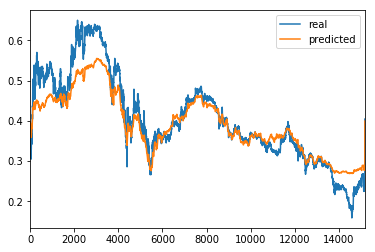

****** XMR ********
MAPE 5.33494031389


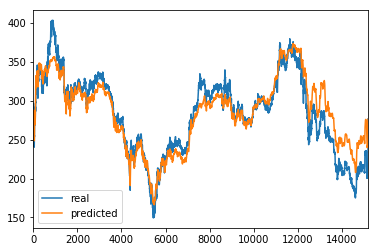

****** XRP ********
MAPE 5.44490748086


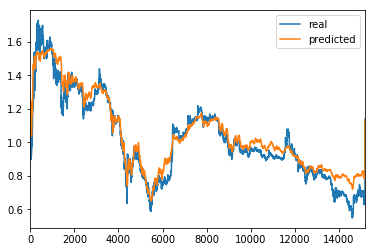

****** ZEC ********
MAPE 5.09646928934


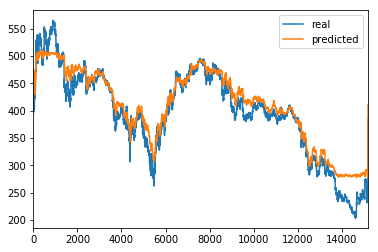

In [126]:
mape_scores = []
for coin in list(df.columns.values):
    real = Y[coin]
    predicted = results[coin]
    joint = pd.concat([real, predicted], keys=['real', 'predicted'],  axis=1, join='inner')
    print("******", coin , "********")
    print("MAPE", mape(joint.real ,joint.predicted))
    mape_scores.append(mape(joint.real ,joint.predicted))
    joint.plot()
    plt.show()

In [127]:
np.array(mape_scores).mean()

5.1307833167621597